<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

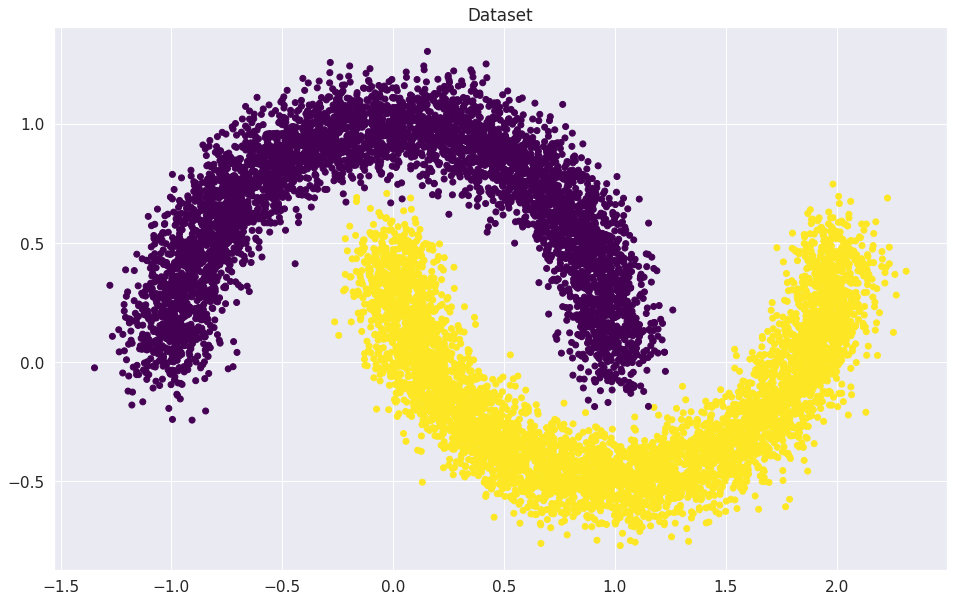

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
y_val_t =  torch.FloatTensor(y_val)
X_val_t =  torch.FloatTensor(X_val)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad=True)

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [9]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from torchinfo import summary

summary(linear_regression, (1, 2), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

**Ответ**: у получившейся модели 3 параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp.view(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5703125
Iteration: 100
Batch accuracy: 0.765625
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.890625
Iteration: 400
Batch accuracy: 0.859375
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 814.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 814

### Визуализируем результаты

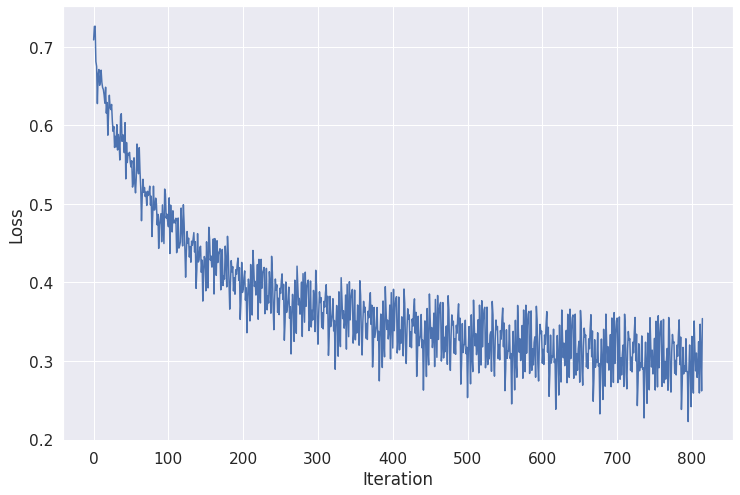

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

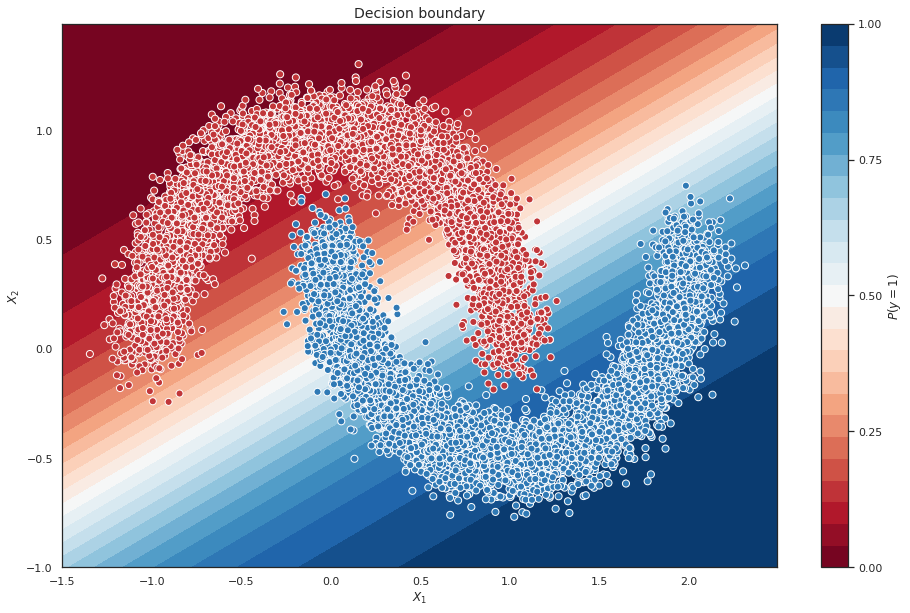

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = torch.sigmoid(model(x_batch))
        preds = (outp > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, preds)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.862

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 503: Service Temporarily Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [21]:
max_epochs = 10
accuracy = {"train": [], "valid": []}


for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = torch.softmax(model(x_batch), dim=1)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()
              
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8938
Loader: valid. Accuracy: 0.9465
Epoch: 2
Loader: train. Accuracy: 0.9525666666666667
Loader: valid. Accuracy: 0.9666
Epoch: 3
Loader: train. Accuracy: 0.9660833333333333
Loader: valid. Accuracy: 0.9645
Epoch: 4
Loader: train. Accuracy: 0.9731333333333333
Loader: valid. Accuracy: 0.9688
Epoch: 5
Loader: train. Accuracy: 0.9772333333333333
Loader: valid. Accuracy: 0.9742
Epoch: 6
Loader: train. Accuracy: 0.9802333333333333
Loader: valid. Accuracy: 0.9754
Epoch: 7
Loader: train. Accuracy: 0.9818666666666667
Loader: valid. Accuracy: 0.9733
Epoch: 8
Loader: train. Accuracy: 0.9847
Loader: valid. Accuracy: 0.9732
Epoch: 9
Loader: train. Accuracy: 0.98585
Loader: valid. Accuracy: 0.9724
Epoch: 10
Loader: train. Accuracy: 0.9868333333333333
Loader: valid. Accuracy: 0.9724


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [22]:
elu_accuracy = accuracy["valid"]

In [23]:
def test_activation_function(activation):
  model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
  )

  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  loaders = {"train": train_dataloader, "valid": valid_dataloader}

  max_epochs = 10
  accuracy = {"train": [], "valid": []}

  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              x_batch, y_batch = x_batch.to(device), y_batch.to(device)
              if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
              else:
                model.eval()
                with torch.no_grad():
                  outp = torch.softmax(model(x_batch), dim=1)
              preds = outp.argmax(-1)
              correct = (preds == y_batch).sum()
              all = len(preds)
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)

  return accuracy["valid"]

In [24]:
plain_accuracy = test_activation_function(Identical)

Epoch: 1
Loader: train. Accuracy: 0.8750166666666667
Loader: valid. Accuracy: 0.8959
Epoch: 2
Loader: train. Accuracy: 0.9031333333333333
Loader: valid. Accuracy: 0.8862
Epoch: 3
Loader: train. Accuracy: 0.9072333333333333
Loader: valid. Accuracy: 0.9152
Epoch: 4
Loader: train. Accuracy: 0.90835
Loader: valid. Accuracy: 0.8981
Epoch: 5
Loader: train. Accuracy: 0.909
Loader: valid. Accuracy: 0.915
Epoch: 6
Loader: train. Accuracy: 0.9127666666666666
Loader: valid. Accuracy: 0.9037
Epoch: 7
Loader: train. Accuracy: 0.9126166666666666
Loader: valid. Accuracy: 0.91
Epoch: 8
Loader: train. Accuracy: 0.9149666666666667
Loader: valid. Accuracy: 0.9135
Epoch: 9
Loader: train. Accuracy: 0.9150166666666667
Loader: valid. Accuracy: 0.9141
Epoch: 10
Loader: train. Accuracy: 0.9144333333333333
Loader: valid. Accuracy: 0.9167


In [25]:
relu_accuracy = test_activation_function(nn.ReLU)

Epoch: 1
Loader: train. Accuracy: 0.8813666666666666
Loader: valid. Accuracy: 0.934
Epoch: 2
Loader: train. Accuracy: 0.94465
Loader: valid. Accuracy: 0.9452
Epoch: 3
Loader: train. Accuracy: 0.9585833333333333
Loader: valid. Accuracy: 0.9615
Epoch: 4
Loader: train. Accuracy: 0.9683333333333334
Loader: valid. Accuracy: 0.9664
Epoch: 5
Loader: train. Accuracy: 0.9721333333333333
Loader: valid. Accuracy: 0.969
Epoch: 6
Loader: train. Accuracy: 0.9758333333333333
Loader: valid. Accuracy: 0.9724
Epoch: 7
Loader: train. Accuracy: 0.9784
Loader: valid. Accuracy: 0.9713
Epoch: 8
Loader: train. Accuracy: 0.9800166666666666
Loader: valid. Accuracy: 0.9727
Epoch: 9
Loader: train. Accuracy: 0.9823666666666667
Loader: valid. Accuracy: 0.972
Epoch: 10
Loader: train. Accuracy: 0.9839666666666667
Loader: valid. Accuracy: 0.9746


In [26]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8824666666666666
Loader: valid. Accuracy: 0.9364
Epoch: 2
Loader: train. Accuracy: 0.9459166666666666
Loader: valid. Accuracy: 0.9607
Epoch: 3
Loader: train. Accuracy: 0.9605666666666667
Loader: valid. Accuracy: 0.9608
Epoch: 4
Loader: train. Accuracy: 0.9681166666666666
Loader: valid. Accuracy: 0.9683
Epoch: 5
Loader: train. Accuracy: 0.9732
Loader: valid. Accuracy: 0.9703
Epoch: 6
Loader: train. Accuracy: 0.9773333333333334
Loader: valid. Accuracy: 0.9743
Epoch: 7
Loader: train. Accuracy: 0.9793333333333333
Loader: valid. Accuracy: 0.9753
Epoch: 8
Loader: train. Accuracy: 0.9822833333333333
Loader: valid. Accuracy: 0.9675
Epoch: 9
Loader: train. Accuracy: 0.9823166666666666
Loader: valid. Accuracy: 0.9726
Epoch: 10
Loader: train. Accuracy: 0.9844
Loader: valid. Accuracy: 0.977


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

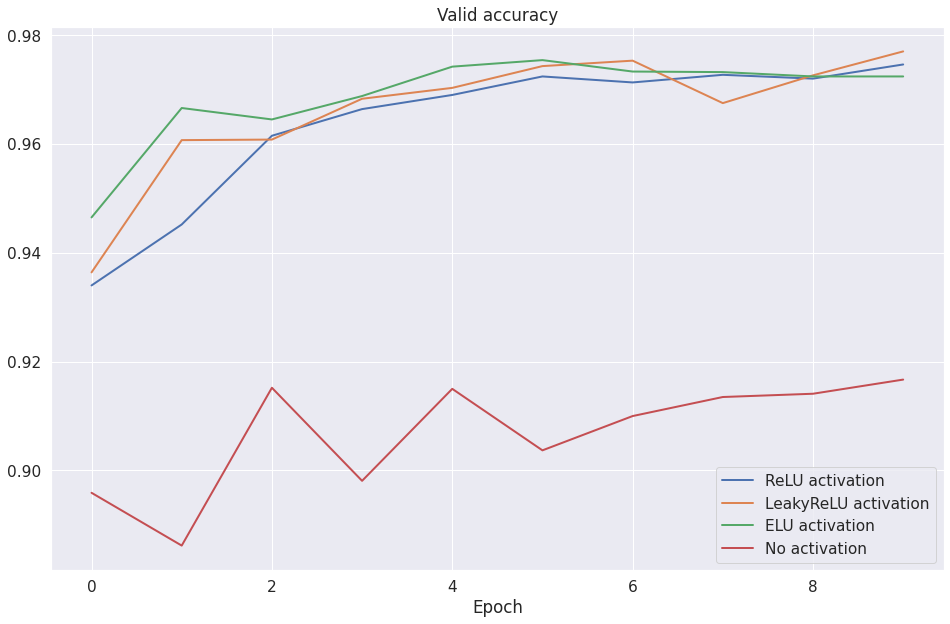

In [27]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

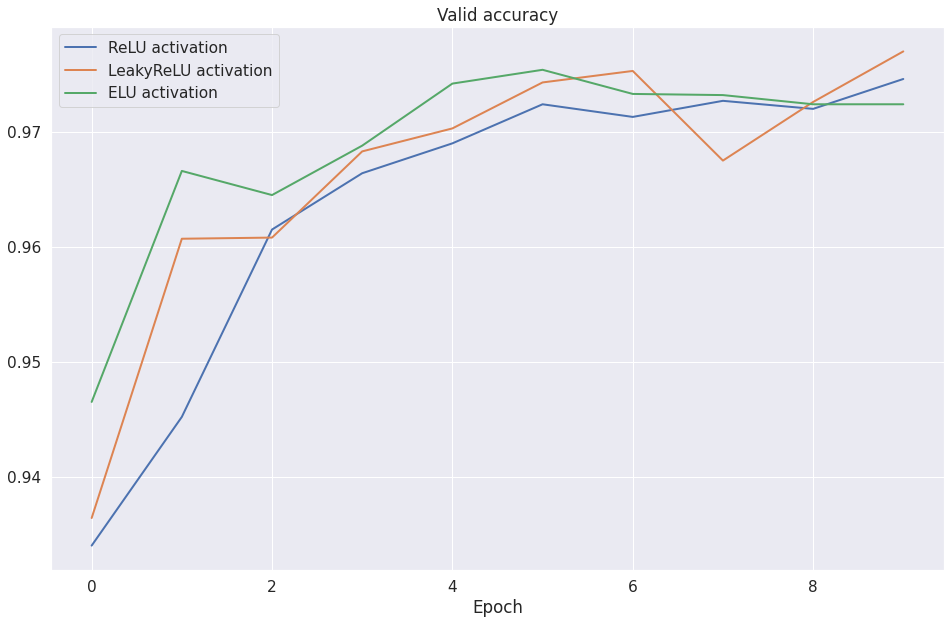

In [28]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [29]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-12-09 19:30:00--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-12-09 19:30:01--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   165KB/s    in 0.3s    

2022-12-09 19:30:02 (165 KB/s) - ‘sample_photo.jpg’ saved [49337/4

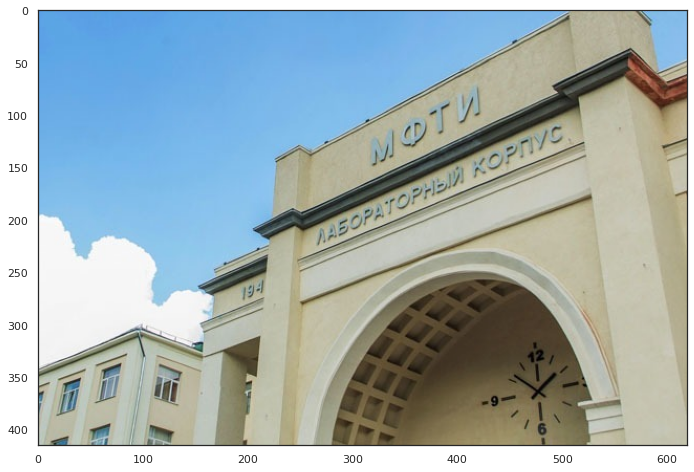

In [30]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

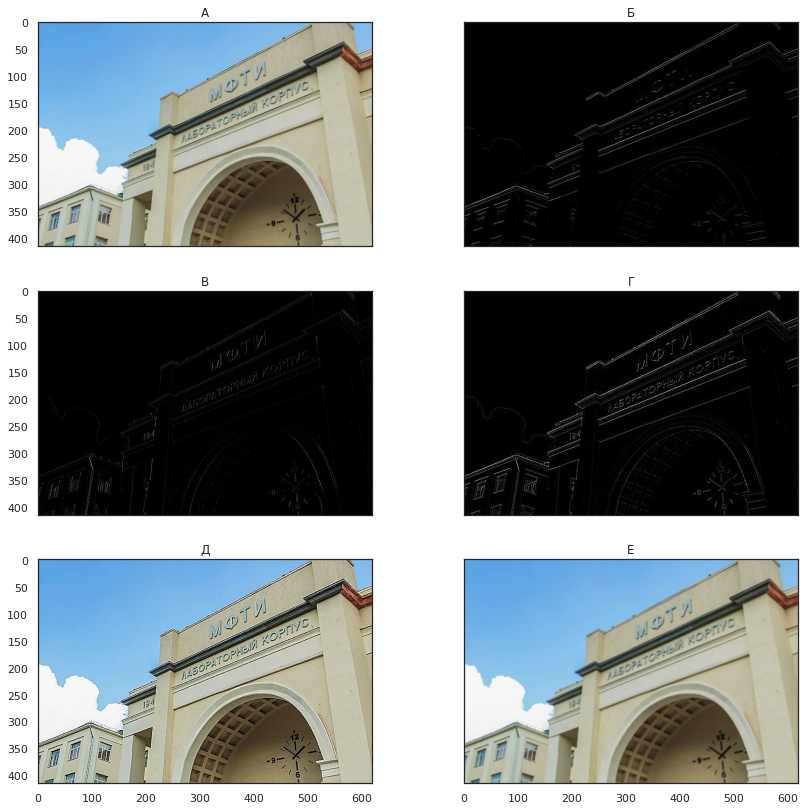

In [31]:
kernels = [
  np.array(([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
  ]), np.float32),

  np.array(([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
  ]), np.float32),

  np.array(([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
  ]), np.float32),

  np.array(([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
  ]), np.float32),

  np.array(([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
  ]), np.float32),

  np.array(([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
  ]), np.float32)
]

fig, axs = plt.subplots(nrows=3, ncols=2 ,
                        figsize=(14, 14),
                        sharey=True, sharex=True)

for pos, (kernel, ax) in enumerate(zip(kernels, axs.flatten())):
    ax.set_title(chr(ord('А') + pos))
    ax.imshow(cv2.filter2D(src=RGB_img, kernel=kernel, ddepth=-1))

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** A3, Б5, В4, Г6, Д2, Е1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [32]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [34]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8982333333333333
Loader: valid. Accuracy: 0.971
Epoch: 2
Loader: train. Accuracy: 0.9731666666666666
Loader: valid. Accuracy: 0.9803
Epoch: 3
Loader: train. Accuracy: 0.9806833333333334
Loader: valid. Accuracy: 0.9816
Epoch: 4
Loader: train. Accuracy: 0.98505
Loader: valid. Accuracy: 0.984
Epoch: 5
Loader: train. Accuracy: 0.9872166666666666
Loader: valid. Accuracy: 0.9862
Epoch: 6
Loader: train. Accuracy: 0.9893666666666666
Loader: valid. Accuracy: 0.9874
Epoch: 7
Loader: train. Accuracy: 0.9906666666666667
Loader: valid. Accuracy: 0.9883
Epoch: 8
Loader: train. Accuracy: 0.9924333333333333
Loader: valid. Accuracy: 0.987
Epoch: 9
Loader: train. Accuracy: 0.99355
Loader: valid. Accuracy: 0.9879
Epoch: 10
Loader: train. Accuracy: 0.9946333333333334
Loader: valid. Accuracy: 0.9884


In [35]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

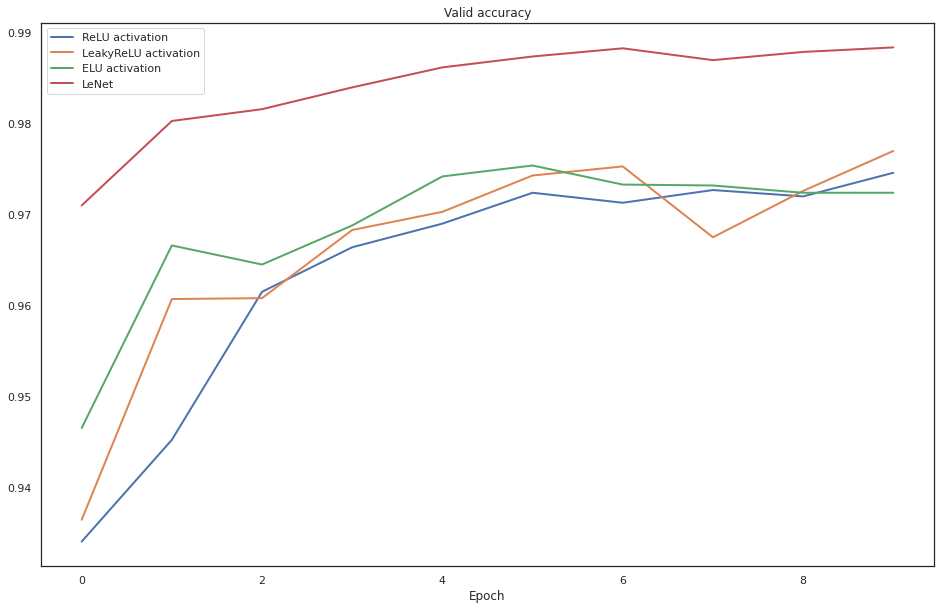

In [36]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99